In [114]:
import pandas as pd
import tensorflow as tf
import numpy as np
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # needed for waffle Charts
mpl.style.use(['ggplot']) # optional: for ggplot-like style
import scipy
from scipy import stats
import sklearn
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D, MaxPooling1D, Softmax, GlobalAveragePooling1D, Bidirectional, GRU, Bidirectional, BatchNormalization, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, losses
from tensorflow import keras, math
import tensorflow_addons as tfa
import keras.backend as K
from itertools import product
import functools
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.xlabel("Epochs")
  plt.ylabel(metric)

In [115]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

gauth = GoogleAuth()
gauth.LocalWebserverAuth() # client_secrets.json need to be in the same directory as the script
drive = GoogleDrive(gauth)

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=547123844257-01v5k81pa5fe8bblcavrtkpu0610f13o.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


In [116]:
# View all folders and file in your Google Drive
fileList = drive.ListFile({'q': "'1if53y8Ffa7Pat2MGvx3o6ukimywOENbD' in parents and trashed=false"}).GetList()
for file in fileList:
  print('Title: %s, ID: %s' % (file['title'], file['id']))
  # Get the folder ID that you want
  if(file['title'] == "To Share"):
      fileID = file['id']

Title: data.csv, ID: 1xdnrj6AZPSqOqJm9ds2aU7kBUIfrUuoK


In [117]:
fileDownloaded = drive.CreateFile({"id":"1xdnrj6AZPSqOqJm9ds2aU7kBUIfrUuoK"})
fileDownloaded.GetContentFile("data.csv")

<a name='2'></a>
## 1 - Data load

First, analyse the data types in our dataset.

In [118]:
df_data = pd.read_csv("data.csv")
df_data.dtypes

ID_usuario      int64
Actividad      object
Fecha           int64
x-acc         float64
y-acc         float64
z-acc          object
dtype: object

In [119]:
df_data.shape

(1098204, 6)

<a name='2'></a>
## 2 - Data cleaning

Now remove unnecessary characters to cast values to the right type. Then remove empty and invalid rows.

In [120]:
df_data['z-acc'] = df_data['z-acc'].str.replace(r';', '')
df_data['z-acc'] = df_data['z-acc'].astype(float)
df_data_pre_cleaned = df_data[df_data['Fecha'] != 0]
df_data_pre_cleaned.shape

(1085361, 6)

In [121]:
df_data_cleaned = df_data_pre_cleaned.dropna()
df_data_cleaned.shape

(1085360, 6)

Valid data      1085360
Removed data      12844
Name: Length, dtype: int64
%Valid data: 0.9883045408685454
%Removed data: 0.01169545913145463
Total number of tiles is 400
Valid data: 395
Removed data: 5


<Figure size 432x288 with 0 Axes>

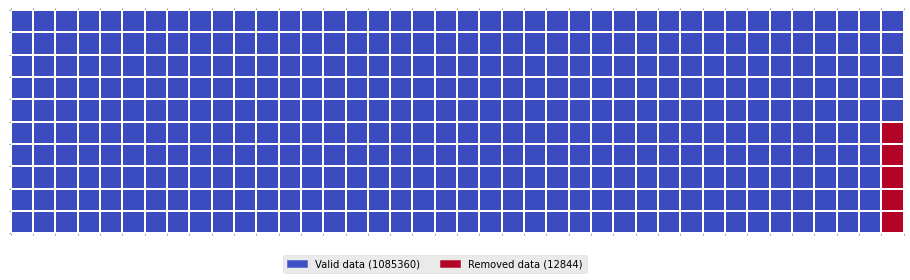

In [122]:
def create_waffle_chart(graph, categories, values, height, width, colormap, value_sign=''):

    # compute the proportion of each category with respect to the total
    total_values = sum(values)
    category_proportions = [(float(value) / total_values) for value in values]
    for i, proportion in enumerate(category_proportions):
        print ("%" + df_dsn.index.values[i] + ': ' + str(proportion))

    # compute the total number of tiles
    total_num_tiles = width * height # total number of tiles
    print ('Total number of tiles is', total_num_tiles)
    
    # compute the number of tiles for each catagory
    tiles_per_category = [round(proportion * total_num_tiles) for proportion in category_proportions]

    # print out number of tiles per category
    for i, tiles in enumerate(tiles_per_category):
        print (df_dsn.index.values[i] + ': ' + str(tiles))
    
    # initialize the waffle chart as an empty matrix
    waffle_chart = np.zeros((height, width))

    # define indices to loop through waffle chart
    category_index = 0
    tile_index = 0

    # populate the waffle chart
    for col in range(width):
        for row in range(height):
            tile_index += 1

            # if the number of tiles populated for the current category 
            # is equal to its corresponding allocated tiles...
            if tile_index > sum(tiles_per_category[0:category_index]):
                # ...proceed to the next category
                category_index += 1       
            
            # set the class value to an integer, which increases with class
            waffle_chart[row, col] = category_index
    
    # instantiate a new figure object
    fig = plt.figure()

    # use matshow to display the waffle chart
    colormap = plt.cm.coolwarm
    plt.matshow(waffle_chart, cmap=colormap)
    #plt.colorbar()

    # get the axis
    ax = plt.gca()

    # set minor ticks
    ax.set_xticks(np.arange(-.5, (width), 1), minor=True)
    ax.set_yticks(np.arange(-.5, (height), 1), minor=True)
    
    # add dridlines based on minor ticks
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

    plt.xticks([])
    plt.yticks([])

    # compute cumulative sum of individual categories to match color schemes between chart and legend
    values_cumsum = np.flip(values)
    total_values = values_cumsum[len(values_cumsum) - 1]
    
    # create legend
    if graph == 1:
        legend_handles = []
        for i, category in enumerate(categories):
            if value_sign == '%':
                label_str = category + ' (' + str(values[i]) + value_sign + ')'
            else:
                label_str = category + ' (' + value_sign + str(values[i]) + ')'

            if i == 1:
                color_val = colormap(float(values[0])/total_values)
            else:
                color_val = colormap(float(values[1])/total_values)
            legend_handles.append(mpatches.Patch(color=color_val, label=label_str))
    elif graph == 2:
        legend_handles = []
        for i, category in enumerate(categories):
            if value_sign == '%':
                label_str = category + ' (' + str(values[i]) + value_sign + ')'
            else:
                label_str = category + ' (' + value_sign + str(values[i]) + ')'
            color_val = colormap(float(values_cumsum[i])/total_values)
            if i == 1:
                legend_handles.append(mpatches.Patch(color="grey", label=label_str))
            else:
                legend_handles.append(mpatches.Patch(color=color_val, label=label_str))


    # add legend to chart
    plt.legend(
        handles=legend_handles,
        loc='lower center', 
        ncol=len(categories),
        bbox_to_anchor=(0., -0.2, 0.95, .1)
    )
#WAFFLE CHART
df_dsn = pd.DataFrame([df_data_cleaned.shape[0],df_data.shape[0]-df_data_cleaned.shape[0]], columns=["Length"], index=["Valid data","Removed data"])
width = 40 # width of chart
height = 10 # height of chart

categories = df_dsn.index.values # categories
values = df_dsn['Length'] # correponding values of categories
print(values)
colormap = plt.cm.coolwarm # color map class

create_waffle_chart(1,categories, values, height, width, colormap)

In [123]:
df_data.head()

,ID_usuario,Actividad,Fecha,x-acc,y-acc,z-acc
0,33,Correr,49105962326000,-0.694638,12.680544,0.503953
1,33,Correr,49106062271000,5.012288,11.264028,0.953424
2,33,Correr,49106112167000,4.903325,10.882658,-0.081722
3,33,Correr,49106222305000,-0.612916,18.496431,3.023717
4,33,Correr,49106332290000,-1.184970,12.108489,7.205164


<a name='2'></a>
## 3 - Data exploration and normalisation

Check important information about the data and standarise the input columns (x-acc, y-acc, z-acc).

In [124]:
df_data.describe()

,ID_usuario,Fecha,x-acc,y-acc,z-acc
count,1.098204e+06,1.098204e+06,1.098204e+06,1.098204e+06,1.098203e+06
mean,1.886066e+01,3.340907e+13,6.628679e-01,7.255639e+00,4.110616e-01
std,1.021423e+01,4.944967e+13,6.849058e+00,6.746204e+00,4.754109e+00
min,1.000000e+00,0.000000e+00,-1.961000e+01,-1.961000e+01,-1.980000e+01
25%,1.000000e+01,2.019113e+12,-2.870000e+00,3.170000e+00,-2.220000e+00
50%,1.900000e+01,9.722777e+12,2.700000e-01,7.930000e+00,0.000000e+00
75%,2.800000e+01,4.996570e+13,4.440000e+00,1.156000e+01,2.720000e+00
max,3.600000e+01,2.093974e+14,1.995000e+01,2.004000e+01,1.961000e+01


In [125]:
df_hist=df_data_cleaned.groupby("Actividad").count()
df_hist.head(6)

,ID_usuario,Fecha,x-acc,y-acc,z-acc
Actividad,,,,,
BajarEscaleras,100194,100194,100194,100194,100194
Caminar,423905,423905,423905,423905,423905
Correr,330330,330330,330330,330330,330330
Parado,48394,48394,48394,48394,48394
Sentado,59939,59939,59939,59939,59939
SubirEscaleras,122598,122598,122598,122598,122598


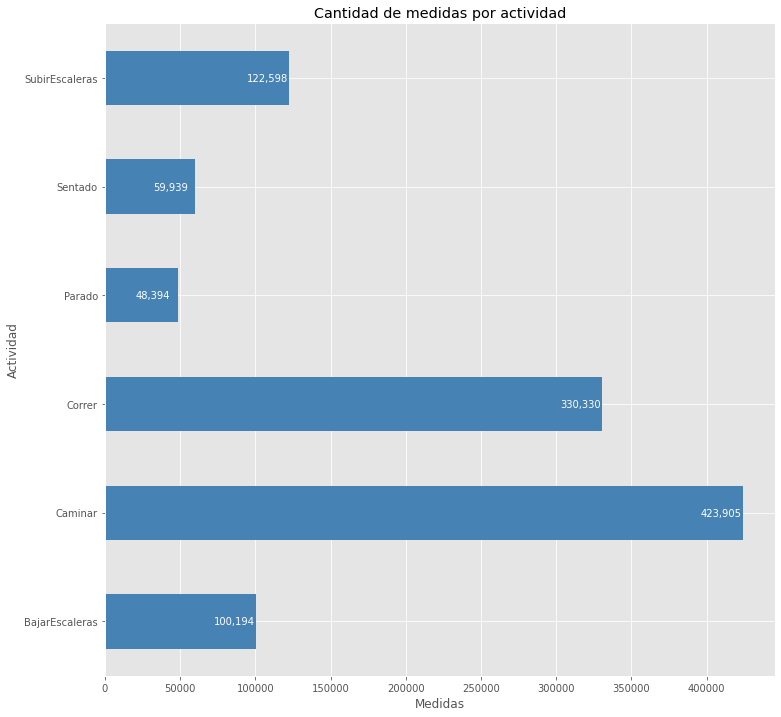

In [126]:
df_hist.plot(kind='barh', figsize=(12, 12), color='steelblue', legend=None)
plt.xlabel('Medidas')
plt.title('Cantidad de medidas por actividad')

    # annotate value labels to each country
for index, value in enumerate(df_hist["x-acc"]): 
    label = format(int(value), ',') # format int with commas
    # place text at the end of bar (subtracting 47000 from x, and 0.1 from y to make it fit within the bar)
    plt.annotate(label, xy=(value - 28000, index - 0.03), color='white')

plt.show()

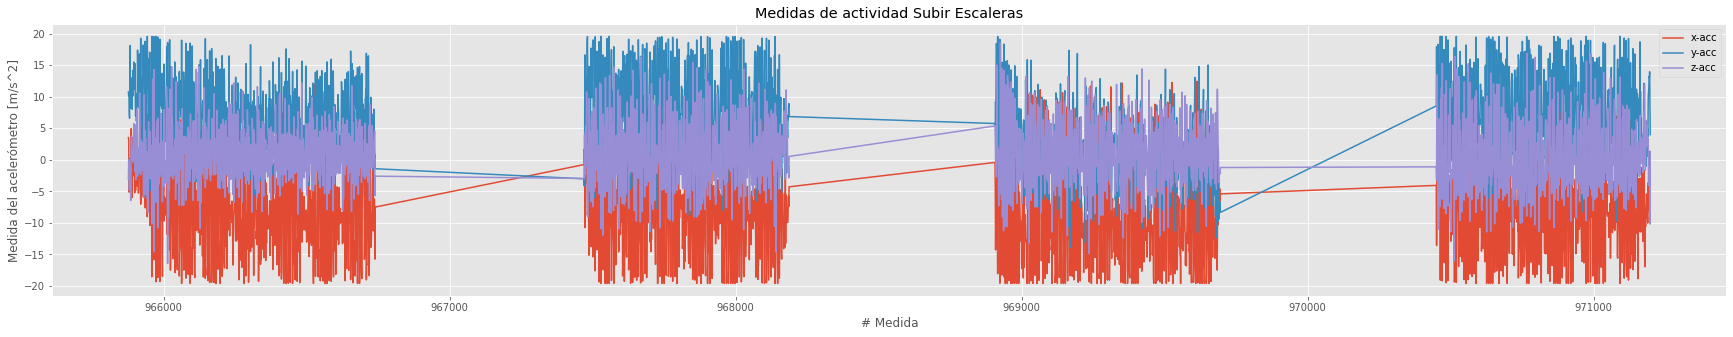

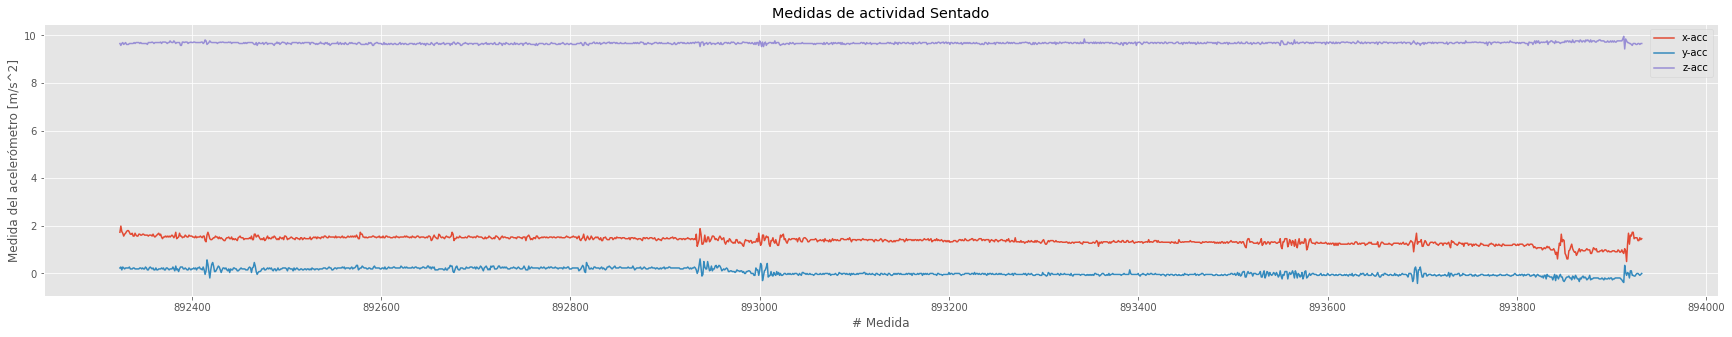

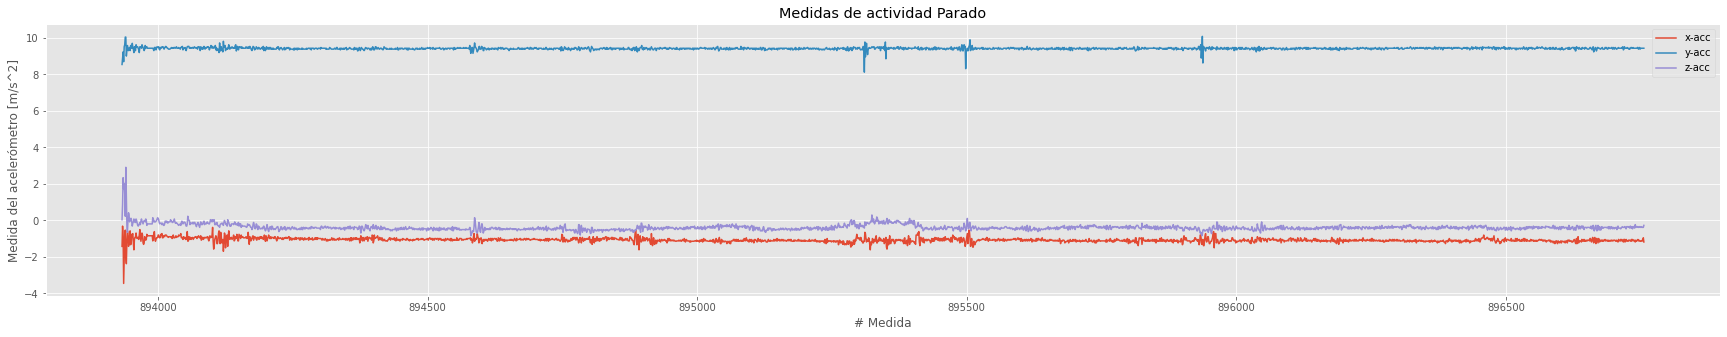

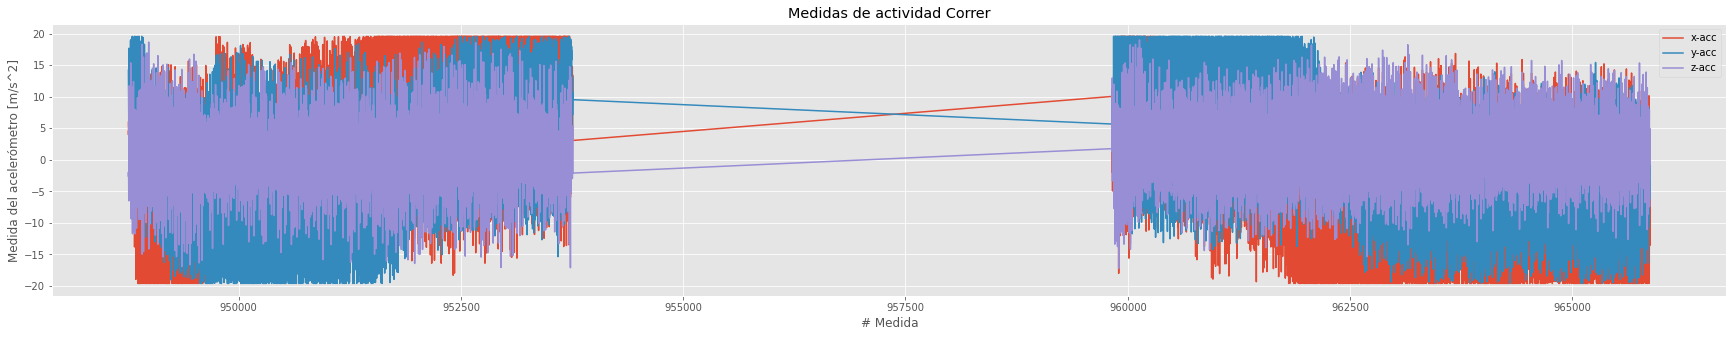

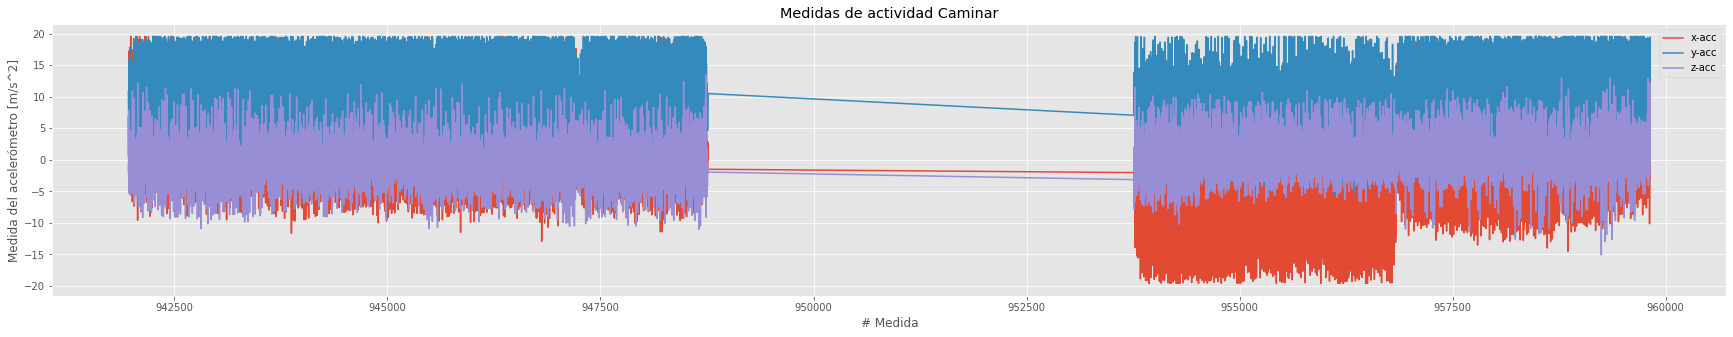

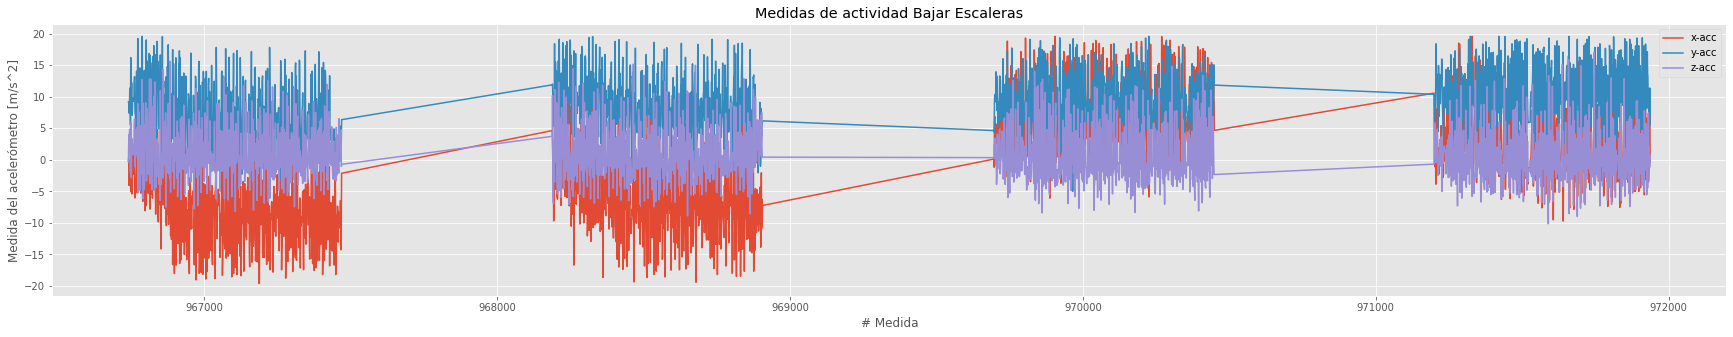

In [127]:
df_data_cleaned.loc[(df_data_cleaned["Actividad"]=="SubirEscaleras")&(df_data_cleaned["ID_usuario"]==1)].drop(columns=["ID_usuario","Fecha"]).plot(kind='line',figsize=(30, 5))
plt.title('Medidas de actividad Subir Escaleras')
plt.ylabel('Medida del acelerómetro [m/s^2]')
plt.xlabel('# Medida')

df_data_cleaned.loc[(df_data_cleaned["Actividad"]=="Sentado")&(df_data_cleaned["ID_usuario"]==3)].drop(columns=["ID_usuario","Fecha"]).plot(kind='line',figsize=(30, 5))
plt.title('Medidas de actividad Sentado')
plt.ylabel('Medida del acelerómetro [m/s^2]')
plt.xlabel('# Medida')

df_data_cleaned.loc[(df_data_cleaned["Actividad"]=="Parado")&(df_data_cleaned["ID_usuario"]==3)].drop(columns=["ID_usuario","Fecha"]).plot(kind='line',figsize=(30, 5))
plt.title('Medidas de actividad Parado')
plt.ylabel('Medida del acelerómetro [m/s^2]')
plt.xlabel('# Medida')

df_data_cleaned.loc[(df_data_cleaned["Actividad"]=="Correr")&(df_data_cleaned["ID_usuario"]==1)].drop(columns=["ID_usuario","Fecha"]).plot(kind='line',figsize=(30, 5))
plt.title('Medidas de actividad Correr')
plt.ylabel('Medida del acelerómetro [m/s^2]')
plt.xlabel('# Medida')

df_data_cleaned.loc[(df_data_cleaned["Actividad"]=="Caminar")&(df_data_cleaned["ID_usuario"]==1)].drop(columns=["ID_usuario","Fecha"]).plot(kind='line',figsize=(30, 5))
plt.title('Medidas de actividad Caminar')
plt.ylabel('Medida del acelerómetro [m/s^2]')
plt.xlabel('# Medida')

df_data_cleaned.loc[(df_data_cleaned["Actividad"]=="BajarEscaleras")&(df_data_cleaned["ID_usuario"]==1)].drop(columns=["ID_usuario","Fecha"]).plot(kind='line',figsize=(30, 5))
plt.title('Medidas de actividad Bajar Escaleras')
plt.ylabel('Medida del acelerómetro [m/s^2]')
plt.xlabel('# Medida')

plt.show()

In [128]:

for acc_axis in ["x","y","z"]:
    df_data_cleaned["{}-acc".format(acc_axis)]=(df_data_cleaned["{}-acc".format(acc_axis)]-df_data_cleaned["{}-acc".format(acc_axis)].mean())/df_data_cleaned["{}-acc".format(acc_axis)].std()
df_data_cleaned.head()

<ipython-input-128-c68dd6ab8224>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_cleaned["{}-acc".format(acc_axis)]=(df_data_cleaned["{}-acc".format(acc_axis)]-df_data_cleaned["{}-acc".format(acc_axis)].mean())/df_data_cleaned["{}-acc".format(acc_axis)].std()


,ID_usuario,Actividad,Fecha,x-acc,y-acc,z-acc
0,33,Correr,49105962326000,-0.198190,0.792216,0.018408
1,33,Correr,49106062271000,0.630212,0.582032,0.112401
2,33,Correr,49106112167000,0.614395,0.525444,-0.104069
3,33,Correr,49106222305000,-0.186327,1.655183,0.545341
4,33,Correr,49106332290000,-0.269365,0.707334,1.419765


<a name='2'></a>
## 4 - Output encoding

Turn the target labelled row into a categorical value ranging from 0 to 5.

In [129]:
df_data_cleaned["Actividad"] = df_data_cleaned["Actividad"].astype('category')
df_data_cleaned["Actividad"] = df_data_cleaned["Actividad"].cat.codes
df_data_cleaned.head()

<ipython-input-129-d3400427b2cb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_cleaned["Actividad"] = df_data_cleaned["Actividad"].astype('category')
<ipython-input-129-d3400427b2cb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_cleaned["Actividad"] = df_data_cleaned["Actividad"].cat.codes


,ID_usuario,Actividad,Fecha,x-acc,y-acc,z-acc
0,33,2,49105962326000,-0.198190,0.792216,0.018408
1,33,2,49106062271000,0.630212,0.582032,0.112401
2,33,2,49106112167000,0.614395,0.525444,-0.104069
3,33,2,49106222305000,-0.186327,1.655183,0.545341
4,33,2,49106332290000,-0.269365,0.707334,1.419765


In [130]:
df_values_weight = df_data_cleaned.groupby("Actividad").count()
df_values_weight["Código"]=["Bajar escaleras","Caminar","Correr","Parado","Sentado","Subir escaleras"]
df_values_weight.head(6)

,ID_usuario,Fecha,x-acc,y-acc,z-acc,Código
Actividad,,,,,,
0,100194,100194,100194,100194,100194,Bajar escaleras
1,423905,423905,423905,423905,423905,Caminar
2,330330,330330,330330,330330,330330,Correr
3,48394,48394,48394,48394,48394,Parado
4,59939,59939,59939,59939,59939,Sentado
5,122598,122598,122598,122598,122598,Subir escaleras


In [131]:
df_data_cleaned.groupby("Actividad").count()

,ID_usuario,Fecha,x-acc,y-acc,z-acc
Actividad,,,,,
0,100194,100194,100194,100194,100194
1,423905,423905,423905,423905,423905
2,330330,330330,330330,330330,330330
3,48394,48394,48394,48394,48394
4,59939,59939,59939,59939,59939
5,122598,122598,122598,122598,122598


<a name='2'></a>
## 5 - Data split

Select the number of samples and choose the train-dev-set separation criteria.

/home/daniel/.local/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Training set       4823
Development set     602
Test Set            602
Name: Length, dtype: int64
%Training set: 0.8002322880371661
%Development set: 0.09988385598141696
%Test Set: 0.09988385598141696
Total number of tiles is 576
Training set: 461
Development set: 58
Test Set: 58


<Figure size 432x288 with 0 Axes>

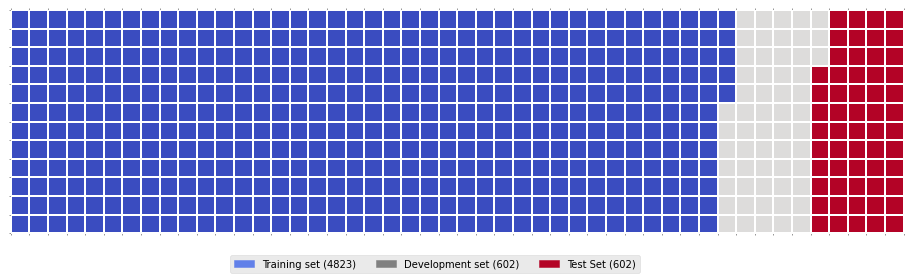

In [132]:
size=180
samples=int(np.floor(df_data_cleaned.shape[0]/size))
df_data_cleaned.drop(df_data_cleaned.tail(df_data_cleaned.shape[0]-samples*size).index,inplace=True)
train_perc=80
dev_perc=10
test_perc=10
train_samples=int(samples*train_perc/100)
global dev_samples
dev_samples=int(samples*dev_perc/100)
test_samples=int(samples*test_perc/100)

#WAFFLE CHART
df_dsn = pd.DataFrame([train_samples,dev_samples,test_samples], columns=["Length"], index=["Training set", "Development set", "Test Set"])
width = int(samples*0.008) # width of chart
height = int(samples*0.002) # height of chart

categories = df_dsn.index.values # categories
values = df_dsn['Length'] # correponding values of categories
print(values)
colormap = plt.cm.coolwarm # color map class

create_waffle_chart(2, categories, values, height, width, colormap)


<a name='2'></a>

Shuffle the samples and target the mode of each sequence.

Text(0.5, 0, '# Medida')

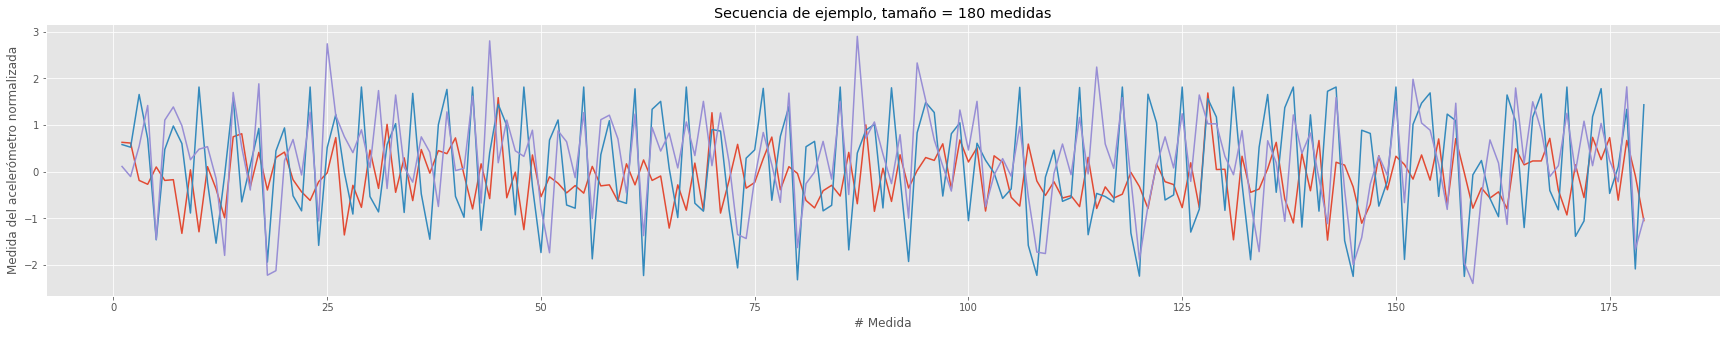

In [133]:
X_train=np.zeros([train_samples,size,3])
Y_train=np.zeros([train_samples,1])
X_dev=np.zeros([dev_samples,size,3])
Y_dev=np.zeros([dev_samples,1])
X_test=np.zeros([test_samples,size,3])
Y_test=np.zeros([test_samples,1])

X=df_data_cleaned[['x-acc','y-acc','z-acc']]
Y=df_data_cleaned[['Actividad']]

X_split=np.split(X,samples)

Y_split=np.split(Y,samples)

c = list(zip(X_split, Y_split))

random.shuffle(c)

X_split, Y_split = zip(*c)

for i in range(0,train_samples):
    X_train[i,:,:]=X_split[i]
    Y_train[i,:]=stats.mode(Y_split[i]).mode
    if i < dev_samples:
        X_dev[i,:,:]=X_split[train_samples+i]
        Y_dev[i,:]=stats.mode(Y_split[train_samples+i]).mode
    if i < test_samples:
        X_test[i,:,:]=X_split[dev_samples+i]
        Y_test[i,:]=stats.mode(Y_split[dev_samples+i]).mode

plt.figure(figsize=(30, 5))
plt.plot(X[1:size])
plt.title('Secuencia de ejemplo, tamaño = {} medidas'.format(size))
plt.ylabel('Medida del acelerómetro normalizada')
plt.xlabel('# Medida')

<a name='2'></a>
## 6 - Create the model

Use a LSTM layer followed by a fully connected layer and a softmax layer to generate the output.

In [153]:
def modelf(input_shape):
    """
    Function creating the model's graph in Keras.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)

    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
    X = LSTM(60,return_sequences = True)(X_input)
    X = Dropout(0.5)(X)
    X = Conv1D(10,size)(X)
    X = MaxPooling1D(pool_size=size, padding='same')(X)
    X = Dense(6, activation='softmax')(X)
    

    model = Model(inputs = X_input, outputs = X)
    
    return model  

In [154]:
model = modelf(input_shape = (size,3))

model.summary()


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 180, 3)]          0         
                                                                 
 lstm_6 (LSTM)               (None, 180, 60)           15360     
                                                                 
 dropout_6 (Dropout)         (None, 180, 60)           0         
                                                                 
 conv1d_6 (Conv1D)           (None, 1, 10)             108010    
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 1, 10)            0         
 1D)                                                             
                                                                 
 dense_6 (Dense)             (None, 1, 6)              66        
                                                           

In [155]:
unique, counts = np.unique(Y_train, return_counts=True)
dict_weights=dict(zip(unique, np.sum(counts)/(6*counts)))
print(dict_weights)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

{0.0: 1.8104354354354355, 1.0: 0.4226253066947073, 2.0: 0.544602529358627, 3.0: 3.7562305295950154, 4.0: 3.1156330749354004, 5.0: 1.519533711405167}


<a name='2'></a>
## 7 - Train the model

Use an Adam optimizer with learning rate decay. Loss will be CategoricalCrossentropy. The stop condition will be set to finish learning after a fixed number of epochs with no more than 0.01 decrease in the weighted loss.

In [156]:
   
opt = Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=8, min_delta=0.01, restore_best_weights=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [157]:
print("The training set shape is: X_train={}, Y_train={}".format(X_train.shape, Y_train.shape))

The training set shape is: X_train=(4823, 180, 3), Y_train=(4823, 1)


In [158]:
history=model.fit(X_train, Y_train, batch_size = 500, epochs=1000, validation_data=(X_dev, Y_dev), callbacks=[callback], class_weight=dict_weights)

Epoch 1/1000
10/10 [==============================] - 4s 281ms/step - loss: 2.4147 - accuracy: 0.2434 - val_loss: 1.4434 - val_accuracy: 0.5033
Epoch 2/1000
10/10 [==============================] - 3s 252ms/step - loss: 1.4641 - accuracy: 0.4323 - val_loss: 1.3639 - val_accuracy: 0.4867
Epoch 3/1000
10/10 [==============================] - 3s 253ms/step - loss: 1.2165 - accuracy: 0.5304 - val_loss: 1.0877 - val_accuracy: 0.5482
Epoch 4/1000
10/10 [==============================] - 3s 255ms/step - loss: 0.9351 - accuracy: 0.6353 - val_loss: 0.8094 - val_accuracy: 0.6827
Epoch 5/1000
10/10 [==============================] - 3s 260ms/step - loss: 0.8146 - accuracy: 0.7035 - val_loss: 0.7397 - val_accuracy: 0.6794
Epoch 6/1000
10/10 [==============================] - 3s 261ms/step - loss: 0.6187 - accuracy: 0.7618 - val_loss: 0.6109 - val_accuracy: 0.7375
Epoch 7/1000
10/10 [==============================] - 3s 261ms/step - loss: 0.5436 - accuracy: 0.7746 - val_loss: 0.5170 - val_accuracy:


<a name='2'></a>
## 8 - Evaluate the model

Create a confusion matrix with your dev set and plot the metrics and loss on every iteration

In [140]:
y_pred = np.argmax(model.predict(X_dev),axis=2)
matrix =  multilabel_confusion_matrix(Y_dev,y_pred,labels=[0,1,2,3,4,5])
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print(matrix)


positive_rights=np.zeros(6)
positive_wrongs=np.zeros(6)
negative_wrongs=np.zeros(6)
negative_rights=np.zeros(6)


for i in range(6):
    positive_rights[i]+=matrix[i,1,1]
    positive_wrongs[i]+=matrix[i,0,1]
    negative_wrongs[i]+=matrix[i,1,0]
    negative_rights[i]+=matrix[i,0,0]




[[[532   9]
  [ 16  45]]

 [[368  14]
  [  1 219]]

 [[411   4]
  [  2 185]]

 [[576   0]
  [  1  25]]

 [[564   1]
  [  0  37]]

 [[524   7]
  [ 15  56]]]


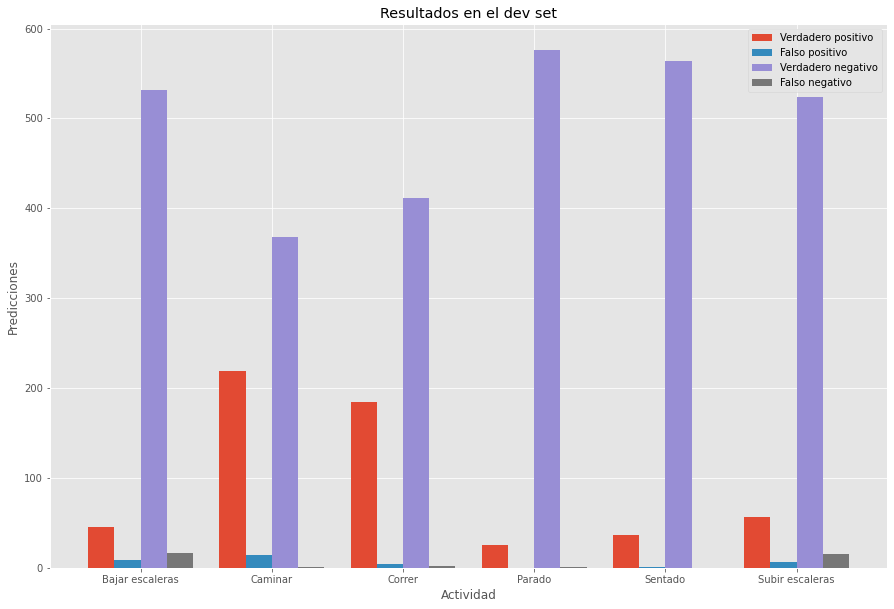

In [141]:
X = ["Bajar escaleras","Caminar","Correr","Parado","Sentado","Subir escaleras"]
true_pos = positive_rights
fal_pos = positive_wrongs
true_neg = negative_rights
fal_neg = negative_wrongs
  
X_axis = np.arange(len(X))
plt.figure(figsize=(15, 10))
plt.bar(X_axis - 0.3, true_pos, 0.2, label = 'Verdadero positivo')
plt.bar(X_axis - 0.1, fal_pos, 0.2, label = 'Falso positivo')
plt.bar(X_axis + 0.1, true_neg, 0.2, label = 'Verdadero negativo')
plt.bar(X_axis + 0.3, fal_neg, 0.2, label = 'Falso negativo')

  
plt.xticks(X_axis, X)
plt.xlabel("Actividad")
plt.ylabel("Predicciones")
plt.title("Resultados en el dev set")
plt.legend()
plt.show()

When making predictions on static activities, there is a clear tendency of high accuracy. However, the activities involving abrupt movements seem harder to guess and are sometimes confused, specially "Subir escaleras" and "Bajar escaleras".

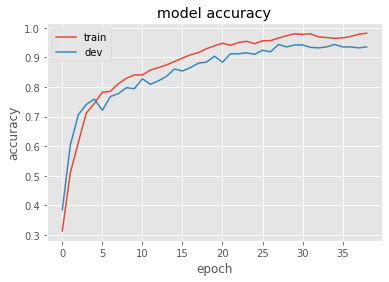

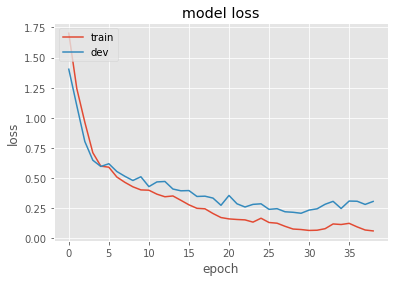

In [142]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

<a name='2'></a>
## 9 - Evaluate the model with the test set


In [143]:
y_pred = np.argmax(model.predict(X_test),axis=2)
matrix =  multilabel_confusion_matrix(Y_test,y_pred,labels=[0,1,2,3,4,5])
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print(matrix)


positive_rights=np.zeros(6)
positive_wrongs=np.zeros(6)
negative_wrongs=np.zeros(6)
negative_rights=np.zeros(6)


for i in range(6):
    positive_rights[i]+=matrix[i,1,1]
    positive_wrongs[i]+=matrix[i,0,1]
    negative_wrongs[i]+=matrix[i,1,0]
    negative_rights[i]+=matrix[i,0,0]

[[[556   2]
  [  1  43]]

 [[373   3]
  [  1 225]]

 [[410   0]
  [  2 190]]

 [[570   0]
  [  0  32]]

 [[571   0]
  [  0  31]]

 [[525   0]
  [  1  76]]]


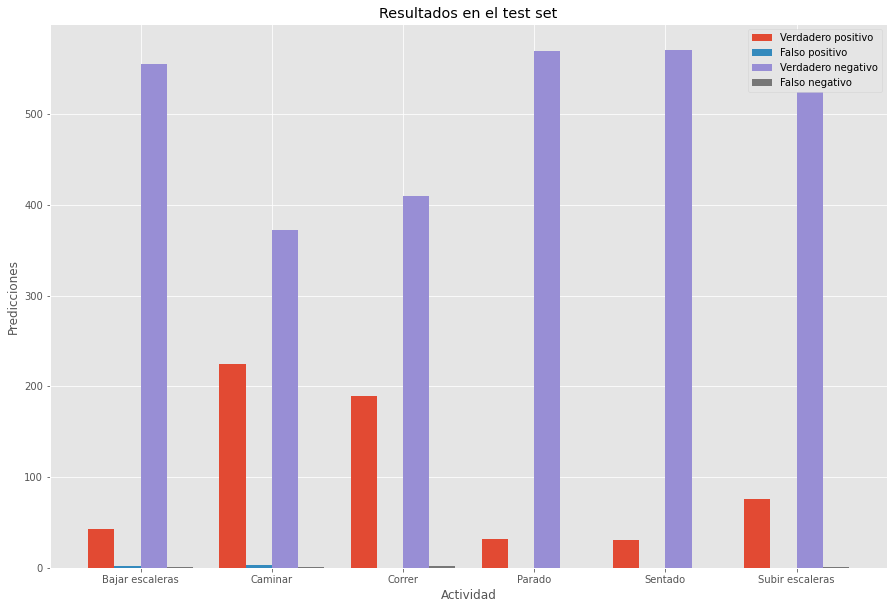

In [146]:
X = ["Bajar escaleras","Caminar","Correr","Parado","Sentado","Subir escaleras"]
true_pos = positive_rights
fal_pos = positive_wrongs
true_neg = negative_rights
fal_neg = negative_wrongs
  
X_axis = np.arange(len(X))
plt.figure(figsize=(15, 10))
plt.bar(X_axis - 0.3, true_pos, 0.2, label = 'Verdadero positivo')
plt.bar(X_axis - 0.1, fal_pos, 0.2, label = 'Falso positivo')
plt.bar(X_axis + 0.1, true_neg, 0.2, label = 'Verdadero negativo')
plt.bar(X_axis + 0.3, fal_neg, 0.2, label = 'Falso negativo')

  
plt.xticks(X_axis, X)
plt.xlabel("Actividad")
plt.ylabel("Predicciones")
plt.title("Resultados en el test set")
plt.legend()
plt.show()

<a name='2'></a>
## 10 - Save/load the model

In [159]:
model.save('/home/daniel/ml-projects/Exercises/1.Smartwatch-physical-activity/3.0/smart-def-target3jan-pooled-dropped.h5')
#model =load_model('/home/daniel/ml-projects/Exercises/1.Smartwatch-physical-activity/models/smart-def-target1.h5')